## Reproductible fitting

In [1]:
from typing import Any, cast

import matplotlib.pyplot as plt
import torch

import jmstate
from jmstate import MultiStateJointModel
from jmstate.jobs import LogParamsHistory, RandomFit, ValueStop
from jmstate.typedefs import HazardFns, ModelData, ModelDesign, ModelParams, SampleData
from jmstate.utils import repr_from_cov

In [ ]:
torch.manual_seed(0)  # type: ignore

def sigmoid(t: torch.Tensor, psi: torch.Tensor):
    scale, offset, slope = psi.chunk(3, dim=-1)
    return (scale * torch.sigmoid((t - offset) / slope)).unsqueeze(-1)


def f(gamma: torch.Tensor | None, x: torch.Tensor | None, b: torch.Tensor):
    psi = cast(torch.Tensor, gamma) + b
    psi[..., 2].exp_()
    return psi


def random_far_apart(
    n: int, m: int, a: torch.Tensor, b: torch.Tensor, min_dist: torch.Tensor
):
    L_free = (b - a) - (m - 1) * min_dist

    y = torch.rand(n, m) * L_free
    y, _ = torch.sort(y, dim=1)

    gap_offset = torch.arange(m) * min_dist

    return a + y + gap_offset

In [3]:
lmda, k = 12.0, 2.0
weibull_fn = jmstate.functions.Weibull(k, lmda)

gamma = torch.tensor([4.0, 6.0, 0.5])

Q = torch.diag(torch.tensor([1.3, 1.9, 0.1]))
R = torch.tensor([[0.6]])

alphas = {("alive", "dead"): torch.tensor([0.4])}
betas = {("alive", "dead"): torch.tensor([-0.9, 0.8, 0.2])}

real_params = ModelParams(
    gamma,
    repr_from_cov(Q, method="diag"),
    repr_from_cov(R, method="ball"),
    alphas,
    betas,
)

Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)

In [4]:
model_design = ModelDesign(
    f, sigmoid, {("alive", "dead"): HazardFns(weibull_fn, sigmoid)}
)

In [5]:
real_model = MultiStateJointModel(model_design, real_params)

n, p = 1000, 3

c = torch.rand(n, 1) * 5.0 + 10.0
x = torch.randn(n, p)

a = torch.zeros(n, 1)
b = torch.rand(n, 1) * 5 + 10
min_dist = (b - a) / 15.0 * 0.7
t = random_far_apart(n, 15, a, b, min_dist)

b = Q_dist.sample((n,))
psi = f(gamma, x, b)

In [6]:
n, m, p = 500, 15, 3
trajectories_init = [[(0.0, "alive")] for _ in range(n)]


def gen_data(n: int, m: int, p: int):
    c = torch.rand(n, 1) * 5 + 10
    x = torch.randn(n, p)

    b = Q_dist.sample((n,))
    psi = f(gamma, x, b)

    a = torch.zeros((n, 1))
    t = random_far_apart(n, m, a, c, 0.7 * c / m)

    sample_data = SampleData(x, trajectories_init, psi)
    trajectories = real_model.sample_trajectories(sample_data, c)

    y = model_design.regression_fn(t, psi).squeeze(0)
    y += R_dist.sample(y.shape[:2])
    y[t > c] = torch.nan

    return x, t, y, trajectories, c

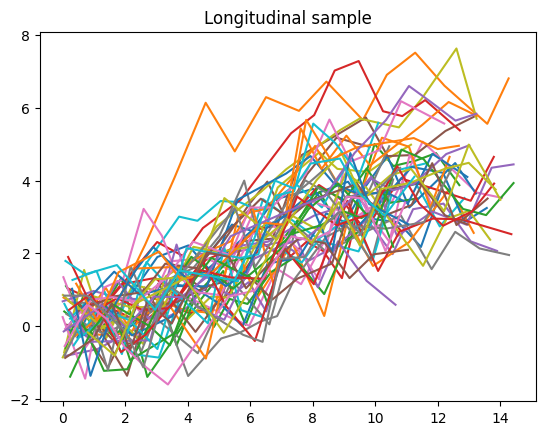

In [7]:
x, t, y, trajectories, c = gen_data(n, m, p)

plt.plot(t[:50].T, y[:50].squeeze(-1).T)  # type: ignore
plt.title("Longitudinal sample")  # type: ignore
plt.show()  # type: ignore

In [8]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    repr_from_cov(torch.eye(Q.size(0)), method="diag"),
    repr_from_cov(torch.eye(R.size(0)), method="full"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = ModelData(x, t, y, trajectories, c)

In [ ]:
model = MultiStateJointModel(model_design, init_params)

metrics = model.do(
    data,
    job_factories=[
        RandomFit(lr=0.1, amsgrad=True),
        LogParamsHistory(),
    ],
    max_iterations=500,
)

Running joint model: 100%|██████████| 500/500 [00:08<00:00, 57.78it/s]


In [10]:
params_dict = model.params_.as_dict
real_params_dict = real_model.params_.as_dict
colors: list[Any] = cast(list[Any], plt.get_cmap("tab10").colors)  # type: ignore

for key, val in params_dict.items():
    if isinstance(val, torch.Tensor):
        plt.plot(  # type: ignore
            torch.cat(
                [
                    cast(torch.Tensor, p.as_dict[key])[None]
                    for p in cast(list[ModelParams], metrics)
                ],
                dim=0,
            )
        )
        for i, true_val in enumerate(real_params_dict[key]):
            plt.axhline(  # type: ignore
                y=cast(torch.Tensor, true_val).item(),
                color=colors[i],
                linestyle="--",
                label=(
                    f"True value of {key}"
                    + (f"({i + 1})" if len(real_params_dict[key]) > 1 else "")
                ),
            )
        plt.title(f"Stochastic optimization of the parameter {key}.")  # type: ignore
        plt.legend()  # type: ignore
        plt.xlabel("Iteration")  # type: ignore
        plt.ylabel("Value")  # type: ignore
        plt.tight_layout()
        plt.savefig(f"figures/{key}.png")  # type: ignore
        plt.show()  # type: ignore
    else:
        for subkey in val:
            plt.plot(  # type: ignore
                torch.cat(
                    [
                        p.as_dict[key][subkey][None]
                        for p in cast(list[ModelParams], metrics)
                    ],
                    dim=0,
                )
            )
            for i, true_val in enumerate(real_params_dict[key][subkey]):
                plt.axhline(  # type: ignore
                    y=true_val.item(),
                    color=colors[i],
                    linestyle="--",
                    label=(
                        f"True value of {key}[{subkey}]"
                        + (
                            f"({i + 1})"
                            if len(real_params_dict[key][subkey]) > 1
                            else ""
                        )
                    ),
                )
            plt.title(f"Stochastic optimization of the parameter {key}[{subkey}].")  # type: ignore
            plt.legend()  # type: ignore
            plt.xlabel("Iteration")  # type: ignore
            plt.ylabel("Value")  # type: ignore
            plt.tight_layout()
            plt.savefig(f"figures/{key}.{subkey}.png")  # type: ignore
            plt.show()  # type: ignore

TypeError: 'Metrics' object is not iterable

In [ ]:
mse = 0.0
n_runs = 10

for _ in range(n_runs):
    x, t, y, trajectories, c = gen_data(n, m, p)
    data = ModelData(x, t, y, trajectories, c)

    model = MultiStateJointModel(model_design, init_params)
    model.do(
        data,
        job_factories=[
            RandomFit(lr=0.1, amsgrad=True),
            ValueStop(),
        ],
        max_iterations=500,
    )

    mse += (real_model.params_.as_flat_tensor - model.params_.as_flat_tensor).pow(
        2
    ).sum().item() / n_runs

print()
print(f"RMSE is equal to {mse**0.5}")

Running joint model:  50%|█████     | 251/500 [00:13<00:13, 17.94it/s]


KeyboardInterrupt: 